# Inicialización del Entorno

## Parámetros Globales

In [1]:
from math import sqrt, pi, erf

MAX_UINT32 = 0xFFFFFFFF
MAX_UINT64 = 0xFFFFFFFFFFFFFFFF
sqrtPi = sqrt(pi)
erf1 = erf(1)
dimensiones = [2, 5, 10]
tamaños = [10**4, 10**5, 10**6]
valores_reales = {d: ((sqrtPi * erf1) / 2) ** d for d in dimensiones}

## Funciones Auxiliares

In [2]:
import ctypes
import tempfile
import subprocess
import os

c_code = r"""
#include <immintrin.h>

int rdseed32(unsigned int *out) {
    int ok;
    for (int i = 0; i < 10; ++i) {
        ok = _rdseed32_step(out);
        if (ok) return 1;
    }
    return 0;
}

int rdseed64(unsigned long long *out) {
    int ok;
    for (int i = 0; i < 10; ++i) {
        ok = _rdseed64_step(out);
        if (ok) return 1;
    }
    return 0;
}
"""

def compile_rdseed_lib():
    with tempfile.NamedTemporaryFile(suffix=".c", delete=False) as f:
        f.write(c_code.encode())
        c_path = f.name

    so_path = c_path.replace(".c", ".so")
    compile_cmd = [
        "gcc", "-shared", "-fPIC", "-O2", "-mrdseed", "-o", so_path, c_path
    ]

    subprocess.check_call(compile_cmd)
    os.remove(c_path)
    return ctypes.CDLL(so_path)

# Cargar lib y configurar argumentos
_rdseed = compile_rdseed_lib()
_rdseed.rdseed32.argtypes = [ctypes.POINTER(ctypes.c_uint)]
_rdseed.rdseed32.restype = ctypes.c_int

_rdseed.rdseed64.argtypes = [ctypes.POINTER(ctypes.c_ulonglong)]
_rdseed.rdseed64.restype = ctypes.c_int

# Funciones públicas
def seed32():
    """
    Intenta generar un entero aleatorio no negativo de 32 bits utilizando la instrucción RDSEED.
    """
    out = ctypes.c_uint()
    if _rdseed.rdseed32(ctypes.byref(out)) == 0:
        raise RuntimeError("RDSEED32 falló después de varios intentos.")
    return out.value

def seed64():
    """
    Intenta generar un entero aleatorio no negativo de 64 bits utilizando la instrucción RDSEED.
    """
    out = ctypes.c_ulonglong()
    if _rdseed.rdseed64(ctypes.byref(out)) == 0:
        raise RuntimeError("RDSEED64 falló después de varios intentos.")
    return out.value


In [3]:
def rotl32(x, k):
    """
    Función auxiliar que calcula la rotación de k bits del número x y devuelve como resultado
    un número de 32 bits.
    """
    return ((x << k) | (x >> (32 - k))) & MAX_UINT32 # Máscara para que sea un numero de 32bits

## Parámetros de los Generadores

In [4]:
# Generador Congruencial Lineal
CGL_STATE = 4155788116
a = 16807
M = 2**31 - 1

# Xorshift (32,64,128)
XOR32_STATE = 3016030231
a_xorshift32 = 13
b_xorshift32 = 17
c_xorshift32 = 15
XOR64_STATE = 17816317102425885533
a_xorshift64 = 1
b_xorshift64 = 13
c_xorshift64 = 45
XOR128_STATE = [8551759191851867145, 9037421324366481566]
a_xorshift128 = 23
b_xorshift128 = 18
c_xorshift128 = 15

# Xoshiro128
XOSHIRO_STATE = [608405726, 470204612, 4172113938, 3888846613]
a_xoshiro128 = 9
b_xoshiro128 = 11
r_xoshiro128 = 17

### Chequeos

In [5]:
from sympy import factorint

factores_primos = factorint(M-1)
es_raiz_primitiva = True

for p in factores_primos:
    if pow(a, (M-1) // p, M) == 1:
        print(f"{a} NO es raíz primitiva de {M}")
        es_raiz_primitiva = False
        break

if es_raiz_primitiva:
    print(f"a = {a} es raíz primitiva de M = {M} y por lo tanto, el periódo K = M-1 del LCG es máximo")

a = 16807 es raíz primitiva de M = 2147483647 y por lo tanto, el periódo K = M-1 del LCG es máximo


In [6]:
print("================== Semillas de los generadores ==================")

# CGL
print(f"CGL_STATE       = {CGL_STATE}")

# Xorshift32
print(f"XOR32_STATE     = {XOR32_STATE}")

# Xorshift64
print(f"XOR64_STATE     = {XOR64_STATE}")

# Xorshift128
print(f"XOR128_STATE    = {XOR128_STATE[0]}, {XOR128_STATE[1]}")

# Xoshiro128
print(f"XOSHIRO_STATE   = {XOSHIRO_STATE[0]}, {XOSHIRO_STATE[1]}, {XOSHIRO_STATE[2]}, {XOSHIRO_STATE[3]}")


================== Semillas de los generadores ==================
CGL_STATE       = 4155788116
XOR32_STATE     = 3016030231
XOR64_STATE     = 17816317102425885533
XOR128_STATE    = 8551759191851867145, 9037421324366481566
XOSHIRO_STATE   = 608405726, 470204612, 4172113938, 3888846613


## Clases

### Generadores

In [33]:
class Generador:
    def __init__(self, nombre, funcion, color, Max_value, estados, parametros):
        self.nombre = nombre
        self.funcion = funcion  # Generador en [0, 1)
        self.color = color
        self.Max_value = Max_value
        self.estados = estados
        self.parametros = parametros  # Diccionario de parámetros usados

    def generar(self):
        """
        Devuelve un número pseudoaleatorio en el intervalo {1,...,K-1}.
        """
        return self.funcion()
    
    def generar_normalizado(self):
        """
        Devuelve un número pseudoaleatorio normalizado en el intervalo (0,1).
        """
        return self.generar() / self.Max_value

    


### Resultados

In [8]:
class ResultadoSimulacion:
    def __init__(self, generador, dimension, N, estimacion, tiempo, error_abs, varianza, ecm):
        self.generador = generador
        self.dimension = dimension
        self.N = N
        self.estimacion = estimacion
        self.tiempo = tiempo
        self.error_abs = error_abs
        self.varianza = varianza
        self.ecm = ecm

    def __repr__(self):
        return (f"{self.generador:12} | d={self.dimension:<2} | N={self.N:<7} | "
                f"Estimación={self.estimacion:.6f} | Error={self.error_abs:.2e} | "
                f"Varianza={self.varianza:.2e} | ECM={self.ecm:.2e} | "
                f"Tiempo={self.tiempo:.2f}s")


# IMPLEMENTACIONES

## Generador Congruencial Lineal (LCG)

In [9]:
def LCG():
    """
    Generador Múltiplicativo de números pseudoaleatorios en el conjunto {1,...,M-1} con parámetros:
    • a = 16807
    • M = 2^31 - 1 = 2147483647
    """
    global CGL_STATE
    CGL_STATE = (a*CGL_STATE) % M 
    return CGL_STATE

## Xorshifts (32,64,128)

In [10]:
def Xorshift32():
    """
    Generador de números pseudoaleatorios en el conjunto {1,...,2^32-1} con estado de 32 bits con parámetros:
    • a = 13
    • b = 17
    • c = 5
    """
    global XOR32_STATE
    XOR32_STATE ^= XOR32_STATE << a_xorshift32 
    XOR32_STATE ^= XOR32_STATE >> b_xorshift32
    XOR32_STATE ^= XOR32_STATE << c_xorshift32
    XOR32_STATE &= MAX_UINT32 # Máscara para que sea un numero de 32bits
    return XOR32_STATE


In [11]:
def Xorshift64():
    """
    Generador de números pseudoaleatorios en el conjunto {1,...,2^64-1} con estado de 64 bits con parámetros:
    • a = 1
    • b = 13
    • c = 45
    """
    global XOR64_STATE
    XOR64_STATE ^= XOR64_STATE >> c_xorshift64
    XOR64_STATE ^= XOR64_STATE << b_xorshift64
    XOR64_STATE ^= XOR64_STATE >> a_xorshift64
    XOR64_STATE &= MAX_UINT64 # Máscara para que sea un numero de 64bits
    return XOR64_STATE

In [12]:
def Xorshift128():
    """
    Generador de números pseudoaleatorios en el conjunto {1,...,2^64-1} con 2 estados de 64 bits con parámetros:
    • a = 23
    • b = 18
    • c = 5
    """
    global XOR128_STATE
    s1 = XOR128_STATE[0]
    s0 = XOR128_STATE[1]
    result = (s0 + s1) & MAX_UINT64 # Máscara para que sea un numero de 64bits
    XOR128_STATE[0] = s0
    s1 ^= s1 << a_xorshift128
    XOR128_STATE[1] = (s1 ^ s0 ^ (s1 >> b_xorshift128) ^ (s0 >> c_xorshift128)) & MAX_UINT64 # Máscara para que sea un numero de 64bits
    return result

## Xoshiro128

In [13]:
def Xoshiro128():
    """
    Generador de números pseudoaleatorios pseudoaleatorios en el conjunto {1,...,2^32-1} de 32 bits con 4 estados de 32 bits con 
    parámetros:
    • a = 9
    • b = 11
    • r = 7
    """
    global XOSHIRO_STATE
    result = (rotl32(XOSHIRO_STATE[0] + XOSHIRO_STATE[3], r_xoshiro128) + XOSHIRO_STATE[0]) & MAX_UINT32 # Máscara para que sea un numero de 32bits
    t = (XOSHIRO_STATE[1] << a_xoshiro128) & MAX_UINT32 # Máscara para que sea un numero de 32bits
    XOSHIRO_STATE[2] ^= XOSHIRO_STATE[0]
    XOSHIRO_STATE[3] ^= XOSHIRO_STATE[1]
    XOSHIRO_STATE[1] ^= XOSHIRO_STATE[2]
    XOSHIRO_STATE[0] ^= XOSHIRO_STATE[3] 
    XOSHIRO_STATE[2] ^= t
    XOSHIRO_STATE[3] =  rotl32(XOSHIRO_STATE[3], b_xoshiro128)
    return result

# SIMULACIONES

In [14]:
import numpy as np
from math import exp
from time import perf_counter as pc

def simular(rng, d ,N):
    """
    Dado un generador de números aleatorios (rng) que devuelve valores en [0,1), estima mediante el método de Monte Carlo
    la integral sobre el hipercubo [0,1]^d usando N muestras. 
    Devuelve:
    • estimación de la integral,
    • tiempo de ejecución,
    • varianza de las estimaciones,
    • error cuadrático medio (ECM).
    """
    muestras = np.empty(N, dtype=np.float64)

    inicio = pc()
    for i in range(N):
        prod = 1
        for _ in range(d):
            X = rng()
            prod *= exp(-1 * X**2)
        muestras[i] = prod
    final = pc()

    estimacion = np.mean(muestras)
    varianza = np.var(muestras)
    sesgo = estimacion - valores_reales[d]
    ecm = varianza / N + sesgo**2

    return estimacion, final-inicio, varianza, ecm

In [34]:
generadores = [
    Generador("LCG", LCG, "#F68E5F", M-1, 1, {"a": a, "M": M}),
    Generador("Xorshift32", Xorshift32, "#F5DD90", MAX_UINT32, 1, {"a": a_xorshift32, "b": b_xorshift32, "c": c_xorshift32}),
    Generador("Xorshift64", Xorshift64, "#949083", MAX_UINT64, 1, {"a": a_xorshift64, "b": b_xorshift64, "c": c_xorshift64}),
    Generador("Xorshift128", Xorshift128, "#324376", MAX_UINT64, 2, {"a": a_xorshift128, "b": b_xorshift128, "c": c_xorshift128}),
    Generador("Xoshiro128", Xoshiro128, "#586BA4", MAX_UINT32, 4, {"a": a_xoshiro128, "b": b_xoshiro128, "r": r_xoshiro128}),
]

In [22]:
resultados = []

for gen in generadores:
    for d in dimensiones:
        valor_real = valores_reales[d]
        for N in tamaños:
            estimacion, tiempo, varianza, ecm = simular(gen.generar_normalizado, d, N)
            error_abs = abs(estimacion - valor_real)
            resultado = ResultadoSimulacion(gen.nombre, d, N, estimacion, tiempo, error_abs, varianza, ecm)
            resultados.append(resultado)
            print(resultado)



LCG          | d=2  | N=10000   | Estimación=0.557250 | Error=4.96e-04 | Varianza=4.67e-02 | ECM=4.92e-06 | Tiempo=0.02s
LCG          | d=2  | N=100000  | Estimación=0.557119 | Error=6.27e-04 | Varianza=4.66e-02 | ECM=8.60e-07 | Tiempo=0.19s
LCG          | d=2  | N=1000000 | Estimación=0.557557 | Error=1.89e-04 | Varianza=4.67e-02 | ECM=8.24e-08 | Tiempo=1.17s
LCG          | d=5  | N=10000   | Estimación=0.233550 | Error=1.23e-03 | Varianza=2.37e-02 | ECM=3.87e-06 | Tiempo=0.03s
LCG          | d=5  | N=100000  | Estimación=0.232462 | Error=1.40e-04 | Varianza=2.27e-02 | ECM=2.47e-07 | Tiempo=0.30s
LCG          | d=5  | N=1000000 | Estimación=0.232571 | Error=2.48e-04 | Varianza=2.26e-02 | ECM=8.40e-08 | Tiempo=2.57s
LCG          | d=10 | N=10000   | Estimación=0.053941 | Error=3.26e-05 | Varianza=2.94e-03 | ECM=2.95e-07 | Tiempo=0.05s
LCG          | d=10 | N=100000  | Estimación=0.054105 | Error=1.31e-04 | Varianza=2.93e-03 | ECM=4.64e-08 | Tiempo=0.45s
LCG          | d=10 | N=1000000 

# Gráficas

## Distribución Individual

In [ ]:
import matplotlib.pyplot as plt
from random import random, seed
seed(42)

def generar_muestras(generador, N):
    """
    Genera N muestras con el generador dado.
    """
    return [generador.generar_normalizado() for _ in range(N)]

def graficar_histogramas(generadores, N):
    """
    Genera histogramas para una lista de generadores.
    """
    num_generadores = len(generadores) + 1
    ncols = 3
    nrows = (num_generadores + ncols - 1) // ncols

    _, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharey=True)
    axes = axes.flatten()

    # Histograma de random()
    muestras_random = [random() for _ in range(N)]
    axes[0].hist(muestras_random, bins=50, color='#F76C5E', alpha=0.7)
    axes[0].set_title('random()')
    axes[0].set_xlabel('Valor')
    axes[0].set_ylabel('Frecuencia')

    # Demás Histogramas
    for i, gen in enumerate(generadores, start=1):
        muestras = generar_muestras(gen, N)
        axes[i].hist(muestras, bins=50, color=gen.color, alpha=0.7)
        axes[i].set_title(gen.nombre)
        axes[i].set_xlabel('Valor')
        if i % ncols == 0:
            axes[i].set_ylabel('Frecuencia')

    plt.suptitle(f'Comparación de distribuciones (N={N})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

graficar_histogramas(generadores, 10_000_000)


## Distribución de a Pares

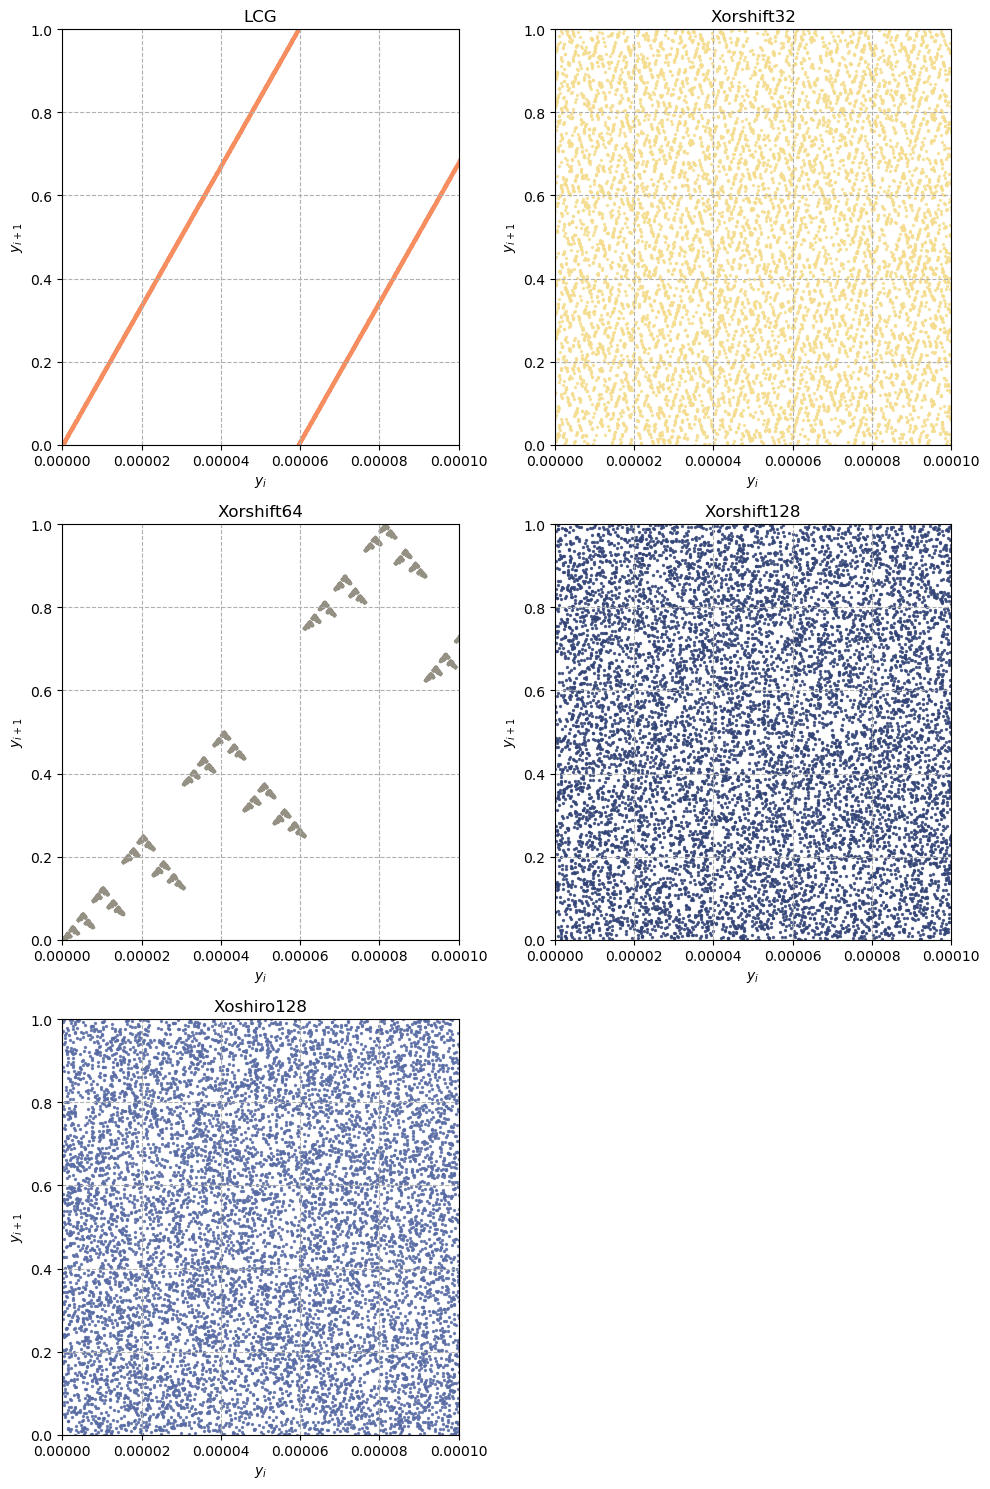

In [ ]:
num_gen = len(generadores)
cols = 2
rows = (num_gen + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()

for i, gen in enumerate(generadores):
    y = np.array([gen.generar_normalizado() for _ in range(100_000_000 + 1)])
    x_vals, y_vals = y[:-1], y[1:]

    ax = axes[i]
    ax.scatter(x_vals, y_vals, s=2.0, color=gen.color, alpha=0.8)
    ax.set_title(f"{gen.nombre}", fontsize=12)
    ax.set_xlabel(r"$y_i$")
    ax.set_ylabel(r"$y_{i+1}$")
    ax.grid(True, linestyle="--", alpha=1.0)
    ax.set_xlim(0.0, 0.0001)
    ax.set_ylim(0.0, 1.0)

 # Si hay subplots vacíos, ocultarlos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Distribución Cubo Unitario

In [36]:
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D  # por compatibilidad
from IPython.display import display, clear_output

def sample_triplets(rng_func, n_triplets):
    """
    Genera una colección de n_triplets puntos en 3D utilizando un generador de números aleatorios normalizado entre 0 y 1.
    """
    xs, ys, zs = [], [], []
    for _ in range(n_triplets):
        xs.append(rng_func())
        ys.append(rng_func())
        zs.append(rng_func())
    return np.array(xs), np.array(ys), np.array(zs)

def plot_3d(xs, ys, zs, elev=30, azim=45, title="", color="b", zoom=1.0):
    """
    Dibuja un gráfico de dispersión 3D con los puntos provistos.
    """
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, s=5, c=color)
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    centro = 0.5
    rango = 0.5 / zoom  # cuanto mayor zoom, menor rango visible
    ax.set_xlim(centro - rango, centro + rango)
    ax.set_ylim(centro - rango, centro + rango)
    ax.set_zlim(centro - rango, centro + rango)
    
    plt.show()

# Widgets
selector = widgets.Dropdown(
    options=[gen.nombre for gen in generadores],
    description='Generador:'
)

slider_elev = widgets.IntSlider(min=0, max=90, step=5, value=30, description='Elevación')
slider_azim = widgets.IntSlider(min=0, max=360, step=5, value=45, description='Azimut')
slider_puntos = widgets.IntSlider(min=1000, max=100000, step=1000, value=10_000, description='Puntos')
slider_zoom = widgets.FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='Zoom')

out = widgets.Output()

def actualizar_plot(_=None):
    """
    Callback para actualizar el gráfico 3D cada vez que cambia un parámetro interactivo.
    """
    with out:
        clear_output(wait=True)
        nombre = selector.value
        gen = next(g for g in generadores if g.nombre == nombre)
        n_puntos = slider_puntos.value
        xs, ys, zs = sample_triplets(gen.generar_normalizado, n_puntos)
        plot_3d(xs, ys, zs,
                elev=slider_elev.value,
                azim=slider_azim.value,
                title=f'Distribución 3D - {gen.nombre}',
                color=gen.color,
                zoom=slider_zoom.value)


grid_sliders = widgets.GridBox(
    children=[slider_puntos, slider_zoom, slider_elev, slider_azim],
    layout=widgets.Layout(
        grid_template_columns="50% 50%",
        grid_template_rows="auto auto",
        grid_gap="10px 10px"
    )
)

selector.observe(actualizar_plot, names='value')
slider_elev.observe(actualizar_plot, names='value')
slider_azim.observe(actualizar_plot, names='value')
slider_puntos.observe(actualizar_plot, names='value')
slider_zoom.observe(actualizar_plot, names='value')

display(widgets.VBox([
    selector,
    grid_sliders
]), out)

actualizar_plot()


Output()

## Costo (ECM × Tiempo)

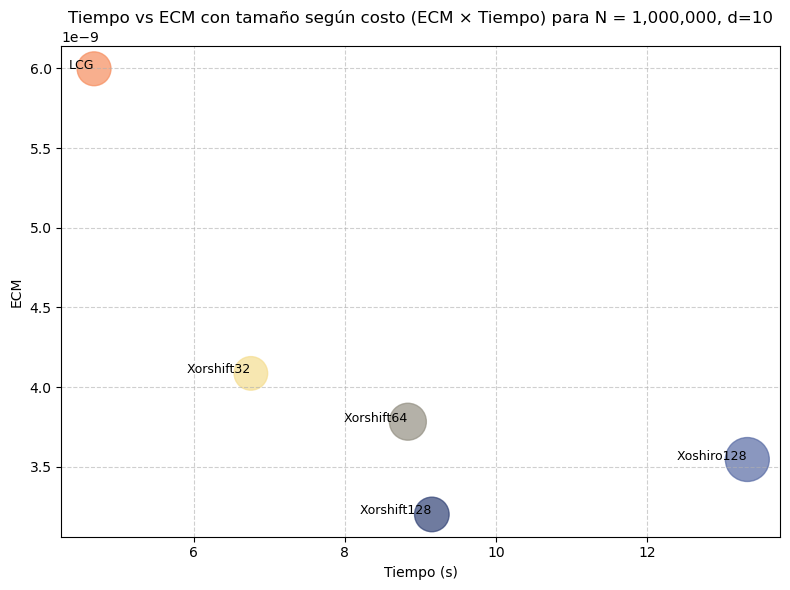

In [35]:
resultados_filtrados = [r for r in resultados if r.dimension == 10 and r.N == 1_000_000]

tiempos = [r.tiempo for r in resultados_filtrados]
ecms = [r.ecm for r in resultados_filtrados]
costos = [r.ecm * r.tiempo for r in resultados_filtrados]
generadores_nombres = [r.generador for r in resultados_filtrados]

# Mapear colores a generadores
# Crear un diccionario nombre -> color a partir del objeto Generador
color_por_generador = {g.nombre: g.color for g in generadores}

# Obtener la lista de colores para cada punto
colores = [color_por_generador.get(nombre, 'gray') for nombre in generadores_nombres]

# Normalizar tamaños para visibilidad
costos_np = np.array(costos)
if costos_np.size > 0:
    tamaños = 1000 * (costos_np / costos_np.max())
else:
    tamaños = []

plt.figure(figsize=(8, 6))
plt.scatter(tiempos, ecms, s=tamaños, c=colores, alpha=0.7)

for j, gen in enumerate(generadores_nombres):
    plt.text(tiempos[j], ecms[j], gen, fontsize=9, ha='right')

plt.xlabel('Tiempo (s)')
plt.ylabel('ECM')
plt.title(f'Tiempo vs ECM con tamaño según costo (ECM × Tiempo) para N = {1_000_000:,}, d=10')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
